In [1]:
from pygame import Rect

pygame 2.0.0.dev3 (SDL 2.0.9, python 3.7.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [177]:
import numpy as np


class NoFit(Exception):
    """The block does not fit inside a texture."""

    
class Tex:
    def __init__(self, size=512):
        self.bounds = Rect(0, 0, size, size)
        self.largest_dim = size
        self.contents = []
        self.free = [self.bounds]

    def _solutions(self, r):
        """Iterate over possible locations for r in this texture."""
        if r.w > self.bounds.w and block.h > self.bounds.h:
            raise NoFit()
        rotations = [r]
        if r.h != r.w:
            rotations.append(Rect(0, 0, r.h, r.w))
            
        # TODO: if we keep self.free sorted we could bisect to find regions that fit?
        for r in rotations:
            for block in self.free:
                if block.w < r.w or block.h < r.h:
                    continue
                    
                yield r, block
        
    def _fitness(self, sol):
        r, block = sol
        
        rect = Rect(block.topleft, r.size)
        return (r.w * r.h) / (block.w * block.h)
        
    def place(self, r):
        if r.w > self.largest_dim or r.h > self.largest_dim:
            raise NoFit()
        try:
            r, block = min(
                self._solutions(r),
                key=self._fitness
            )
        except ValueError as e:
            if e.args[0] != 'min() arg is an empty sequence':
                raise
            raise NoFit() from None
            
        r.topleft = block.topleft    
        self.contents.append(r)
        
        new_free = []
            
        for block in self.free:
            if not block.colliderect(r):
                new_free.append(block)
                continue
                
            new_free.extend([
                Rect(block.left, block.top, block.w, r.top - block.top),  # Above r
                Rect(block.left, r.bottom, block.w, block.bottom - r.bottom),  # Below r
                Rect(block.left, block.top, r.left - block.left, block.h), # Left of r
                Rect(r.right, block.top, block.right - r.right, block.h),  # Right of r 
            ])
            
        self.free = []
        for f in new_free:
            if f.width <= 0 or f.height <= 0:
                continue
                
            if not any(block.contains(f) for block in self.free):
                self.free.append(f)
                
        self.largest_dim = max(min(block.size) for block in self.free)
        return r
        
    
class Packer:
    def __init__(self):
        self.texs = []
        
    def new_tex(self):
        return Tex()
        
    def add(self, r):
        i = -1
        for i, t in enumerate(self.texs):
            try:
                result = t.place(r)
            except NoFit:
                continue
            else:
                return i, result
        new = self.new_tex()
        result = new.place(r)  
        self.texs.append(new)
        return i + 1, result
            

In [178]:
from matplotlib import pyplot as plt

In [181]:
import random
from itertools import combinations

packer = Packer()

by_bin = {}

for i in range(200):
    w = abs(random.normalvariate(50, 10))
    h = abs(random.normalvariate(50, 10))
    bin, loc = packer.add(Rect(0, 0, w, h))
    by_bin.setdefault(bin, []).append(loc)
    
for rects in by_bin.values():
    for ra, rb in combinations(rects, 2):
        if ra.colliderect(rb):
            raise AssertionError(f"{ra} collides with {rb}")
            
for bin_id, rects in by_bin.items():
    bounds = packer.texs[bin_id].bounds
    for r in rects:
        if not bounds.contains(r):
            raise AssertionError(f"{r} is not within bounds {bounds}")

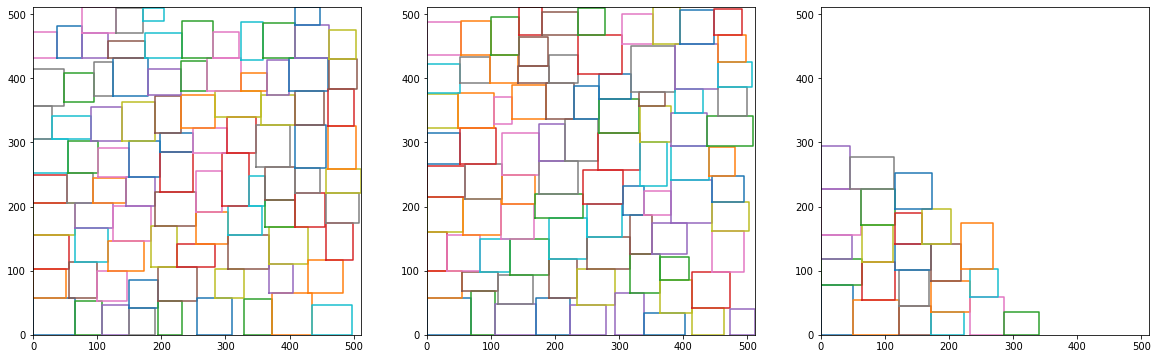

In [182]:
count = max(by_bin) + 1
fig, axes = plt.subplots(1, count, figsize=(20, 8))
if count < 2:
    axes = [axes]

for i, ax in enumerate(axes):
    bin = by_bin.get(i, ())
    ax.set_aspect(1)
    ax.set_xlim(0, 512)
    ax.set_ylim(0, 512)
    for r in bin:
        points = [r.topleft, r.topright, r.bottomright, r.bottomleft, r.topleft]
        xs, ys = zip(*points)
        ax.plot(xs, ys)
        

In [174]:
packer.texs[0]